# Churn: The Road to Low False Negatives and High True Gains
*Project Lead: Aaron Moore*

## Imports

In [1]:
# data acquisition packages
from acquire import get_telco_data
from prepare import clean_telco, prep_telco
from explore import telco_churn_pie, chi_squared_multiple, telco_core_services, chi_squared_single, telco_internet_service_supports, telco_streaming_services
from model import model_prep, telco_best_logit, telco_best_knn, telco_best_rf

# modules for tabular data
import pandas as pd
import numpy as np

# data visual packages
import seaborn as sns
import matplotlib.pyplot as plt

# statistics package for hypothesis testing
from scipy import stats

# modeling packages
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# model evaluation packages
from sklearn.metrics import classification_report, confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Acquire

- The data was acquired by accessing Codeup's MySQL 'telco_churn' database. The data was pulled with a query that joined multiple tables within the database to gather as many relevant datapoints as possible. 
- The data was acquired on March 16th, 2023 and saved in the current working directory for quicker future access. 
- There are 7043 observations and 32 features for each observation. In this data, each observsation represents one customer and each feature represents information about the key services used, add-on services, time with the company, and charges associated with the customer accounts.

## Prepare

> #### Cleaning
>- Identified duplicate features
>- Removed duplicate features
>- Removed features with redundant or unneccesary information
    - There are now 20 features with 7043 observations.
>- Identified missing values
>- Replaced missing values with '0'
>- Altered inappropriate data type from string to float

> #### Preparing
>- Encoded categorical features
    - There are now 46 features
>- Formatted feature names to python friendly names
>- Encoded the target 'churn' 
>- Split the data into train, validate, test, stratifying on 'churn'

> #### Additonal Notes:
> - No null values were identified
> - Features with outliers are not used in the exploration or modeling phases 

In [2]:
# acquiring, cleaning, and splitting the data
train, validate, test = prep_telco(clean_telco(get_telco_data()))

## Explore

### Question 1: What is the companies overall churn rate?

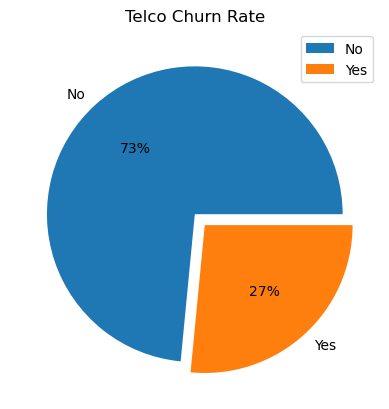

In [3]:
# get telco churn rate pie chart
telco_churn_pie(train)

> #### Takeaways:
>- Roughly a quarter of customers churn
>- All features with over 27% churn rate associated with that feature is a feature of interest

### Question 2: Does churn rate change based on the core service (phone service or internet service) the cutomer has?

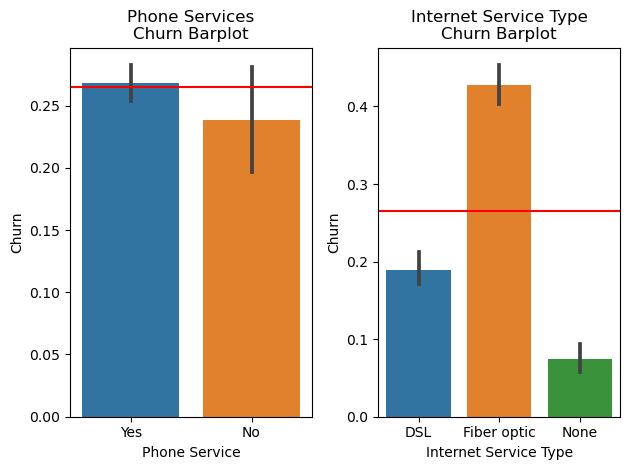

In [4]:
# visuals for core services and their respective churn rates
telco_core_services(train)

> **Takeaways:**
>- While the average customer with phone service at the company does meet the threshhold, there seems to be a balanced split between the two groups
>- There seems to be a direct relationship with internet service type and churn rates, especially with customers having fiber optic internet service.

#### Statistical Testing
Two statistical tests will be performed using $x^2$ tests.

> $x^2$ ***Test: Phone Service and Churn***
>- H$_0$: There is no relationship between churn and phone service.
>- H$_a$: There is a relationship between churn and phone service.
>- Confidence Interval: 95%
>- $a$: 0.05

In [5]:
# get chi-squared results
chi_squared_single(train, 'phone_service')

p-value: 0.2433
chi2: 1.3611
There is not a significant relationship between churn and phone service. 
We cannot reject the Null Hypothesis.


The p-value is greater then $a$. We have evidence to support that a customer's **phone service is not related to churn.** Due to this, we will not include this feature in the modeling phase. We also will not include additional services that require phone service in our future exploration and modeling.

>##### $x^2$ Test: Internet Service Type and Churn
>- H$_0$: There is no relationship between churn and internet service type.
>- H$_a$: There is a relationship between churn and internet service type.
>- Confidence Interval: 95%
>- $a$: 0.05

In [6]:
# getting the p-value, and chi^2 for internet service type
chi_squared_single(train, 'internet_service_type')

p-value: 0.0
chi2: 436.8681
There exists some relationship between churn and internet service type. 
We reject the null hypothesis.


> The p-value is less than $a$. We have evidence to support that **there is a relationship between internet service type and churn.** We will encode internet service type and use it in our modeling phase. We will also further explore services directly related to having internet service.

### Question 3: Do supplementary internet services impact customer churn rates?

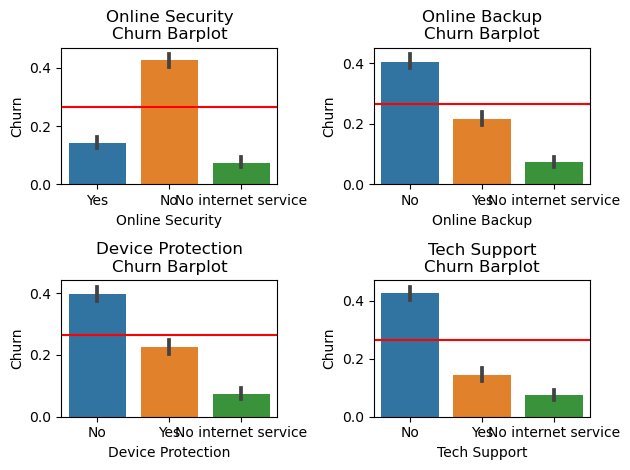

In [7]:
# get internet service support data visuals
telco_internet_service_supports(train)

> **Takeaways:**
>- In all cases, not having supplementary internet service support appears to be associated with a higher churn rate. 
>- Customers without internet service appear to be unlikely divers of churn in the company. These visual give supplementary suport to the the previous finding of internet service tye being a driver of churn.

#### Statistical Testing
Four statistical tests will be performed using $x^2$ tests.

> $x^2$ ***Test: Online Security and Churn***
>- H$_0$: There is no relationship between churn and online security.
>- H$_a$: There is a relationship between churn and online security.
>- Confidence Interval: 95%
>- $a$: 0.05

> $x^2$ ***Test: Online Backup and Churn***
>- H$_0$: There is no relationship between churn and online backup.
>- H$_a$: There is a relationship between churn and online backup.
>- Confidence Interval: 95%
>- $a$: 0.05

> $x^2$ ***Test: Device Protection and Churn***
>- H$_0$: There is no relationship between churn and device protection.
>- H$_a$: There is a relationship between churn and device protection.
>- Confidence Interval: 95%
>- $a$: 0.05

> $x^2$ ***Test: Tech Support and Churn***
>- H$_0$: There is no relationship between churn and tech support.
>- H$_a$: There is a relationship between churn and tech support.
>- Confidence Interval: 95%
>- $a$: 0.05

In [8]:
# getting the chi2 statistics for each feature of interest
chi_squared_multiple(train, ls=['online_security', 'online_backup', 'device_protection', 'tech_support'])



Variable of Interest: ONLINE_SECURITY
p-value:0.0
chi2: 507.5179
There exists some relationship between churn and the online security. 
We reject the null hypothesis.


Variable of Interest: ONLINE_BACKUP
p-value:0.0
chi2: 355.2506
There exists some relationship between churn and the online backup. 
We reject the null hypothesis.


Variable of Interest: DEVICE_PROTECTION
p-value:0.0
chi2: 331.2059
There exists some relationship between churn and the device protection. 
We reject the null hypothesis.


Variable of Interest: TECH_SUPPORT
p-value:0.0
chi2: 504.585
There exists some relationship between churn and the tech support. 
We reject the null hypothesis.


>In all cases, the p-value was less than $a$. There is evidence to support that **there is a relationship between churn and all supplmentary internet support services.** All features explored will be encoded and used in the modeling phase. 

### Question 4: Do streaming services impact customer churn rate?

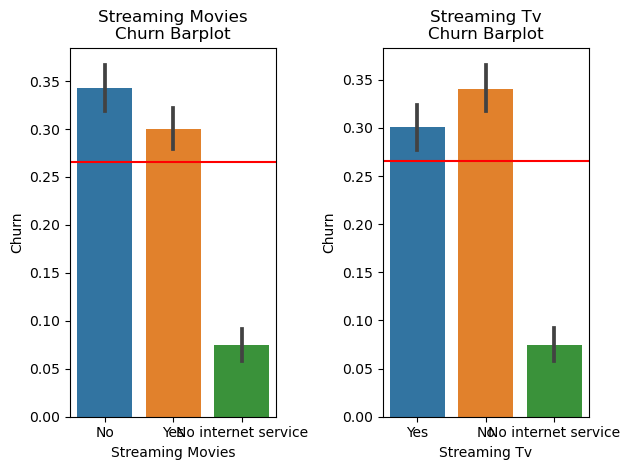

In [9]:
# getting data visuals for streaming tv and streaming movies
telco_streaming_services(train)

>**Takeaways:**
>- Both streaming services appear to impact churn, with higher impact reflected in customers without streaming services.
>- Not having internet service once again appears to not heavily impact churn. This is further visual support to the impact of internet service itself on churn.

#### Statistical Testing
Two statistical tests will be performed using $x^2$ tests.

> $x^2$ ***Test: Streaming Movies and Churn***
>- H$_0$: There is no relationship between churn and streaming movies.
>- H$_a$: There is a relationship between churn and streaming movies.
>- Confidence Interval: 95%
>- $a$: 0.05

> $x^2$ ***Test: Streaming TV and Churn***
>- H$_0$: There is no relationship between churn and streaming tv.
>- H$_a$: There is a relationship between churn and streaming tv.
>- Confidence Interval: 95%
>- $a$: 0.05

In [10]:
# using the chi squared test on the features of interest
chi_squared_multiple(train, ls=['streaming_movies', 'streaming_tv'])



Variable of Interest: STREAMING_MOVIES
p-value:0.0
chi2: 224.567
There exists some relationship between churn and the streaming movies. 
We reject the null hypothesis.


Variable of Interest: STREAMING_TV
p-value:0.0
chi2: 223.4833
There exists some relationship between churn and the streaming tv. 
We reject the null hypothesis.


> In both cases, the p-value was less than $a$. There is evidence to support that **there is a relationship between churn and each streaming service.** Both features will be encoded and used in the modeling phase. 

### Exploration Summary
***Features with significant relationships to churn:***
- Internet service type was found to be a driver of customer churn.
    - Fiber optic internet service appears to be the largest driver of churn within this feature
- All supplementary internet support services (online backup, online securtiy, device protection, and tech support) were all found to be drivers of churn
    - Customers without supplementary internet suport services consistently churn at the highest rate withing each feature.
- Both streaming services (streaming tv and streaming movies) were found to be drivers of churn
    - In both cases, having streaming services and not having streaming services were above the average churn rate. It is possible that this is related to customers with fiber optic internet, the highest driver of churn in the internet service type feature. Due top time constraints, this cannot be explored at this time. 
    
***Feature with an insignificant relationship to churn:***
- Phone service was not found to be a driver of churn.

### Modeling Features
Other categorical features not shown in the exploration secion above were found to have statistically significant relationships to churn. Below is a list of all features that will be used in the modeling phase due to their statistical significance. 
- ***Internet Related Features:***
    - Internet Service Type
    - Online Backup
    - Online Securtiy
    - Device Protection
    - Tech Support
    - Streaming TV
    - Streaming Movies
- ***Customer Characteristic Features:***
    - Senior Citizen
    - Partner
    - Dependents
- ***Customer Account Features:***
     - Contract Type
     - Paperless Billing
     - Payment Type

## Modeling

In [11]:
# get encoded train, validate, and test sets
train, validate, test = prep_telco(train, base_explore=False)

In [12]:
# prep data for modeling
X_train, y_train, X_val, y_val, X_test, y_test = model_prep(train, validate, test)

### Introduction

- The models will be evaluated with two metrics: ***false negative rates and accuracy***. 
    - False negatives represent incorrectly predicting a customer will not churn, but they actually do churn. This metric is selected for the negative unexpected financial consequences related to incorrectly predicting customers not churning. 
    - While false negative rates are the priority, high overall accuracy is still essential. Accurately predicting churn outcomes will position the company to comprehensively and confidently make decisions about the future. 
- Baseline Accuracy Rate: ***73.47%***
    - The baseline was calculated by finding the most common churn outcome, which was not churning, and using that as the baseline predicted outcome. The baseline false negative rate will not be used as a metric for model comparison due to the nature of a baseline. In this case, the baseline has no true positives or false negatives, only true negatives. 

##### Random Forest

In [13]:
# running random forest model and printing results
telco_best_rf(X_train, y_train, X_val, y_val)


        Model: Random Forest | Max Depth 4
        
        False Negative on Train: 33.09%
        False Negative on Validate/Test: 29.41%
        False Negative Difference: 3.67%
        
        Accuracy on Train: 77.57%
        Accuracy on Validate/Test: 78.67%
        Accuracy Difference: -1.10%
        


##### K-Nearest Neighbors

In [14]:
# running KNN model model and printing results
telco_best_knn(X_train, y_train, X_val, y_val)


        Model: KNN | 18 Neighbors
        
        False Negative on Train: 34.44%
        False Negative on Validate/Test: 42.47%
        False Negative Difference: -8.03%
        
        Accuracy on Train: 80.24%
        Accuracy on Validate/Test: 76.98%
        Accuracy Difference: 3.26%
        


##### Logistic Regression

In [15]:
# running Logistic Regression model and printing results
telco_best_logit(X_train, y_train, X_val, y_val)


        Model: Logistic Regression
        
        False Negative on Train: 32.29%
        False Negative on Validate/Test: 24.51%
        False Negative Difference: 7.78%
        
        Accuracy on Train: 77.03%
        Accuracy on Validate/Test: 78.99%
        Accuracy Difference: -1.96%
        


### Comparing Models
- Random Forest and Logistic Regression models performed roughly 3% better on accuracy than the baseline, with the KNN model performing slightly better than both.
- While the KNN model performed best on accuracy, it performed better by only 2% and it's false negative rate performed worst. Between Logistic Regression and Random Forest, both false negative rates are very close, but the difference between the train and validite data sets is larger in the Logistic Regression model.
- The Random Forest model will be used to on the test data due to the lower false negative difference. 

### Test Model

In [16]:
# running random forest model on test data set and printing results
telco_best_rf(X_train, y_train, X_test, y_test)


        Model: Random Forest | Max Depth 4
        
        False Negative on Train: 32.82%
        False Negative on Validate/Test: 33.33%
        False Negative Difference: -0.51%
        
        Accuracy on Train: 77.48%
        Accuracy on Validate/Test: 77.19%
        Accuracy Difference: 0.29%
        


### Modeling Wrap

- The Random Forest model exceeded the baseline accuracy and received the lowest false negative rate of all models on the test dataset. I would not reccommend this model to production due to the still relatively high false negative rate. 

## Conclusion

**Summary**

- Roughly 27% of customers churn
- Churn drivers for churn include internet service type (specifically fiber optic), the lack of supplementary internet support services, and streaming services. 
- The discovered drivers led to a successful model when only surpassing the baseline is used as a metric, but when incorporating false negative rates I consider all of the models a failure. 

**Recommendations**

- Compile customer complaint data from emails, phone calls, and website submissions. This data can be used to increase awareness of what drives to churn.
- Apply research-based retention strategies for customers with fiber optic internet. Fiber optic internet service had the highest churn rate out of all features. While specifics of what exactly causes this customer group to churn are not yet known, it is an area the requires customer retention efforts.

**Next steps**

- Address outliers in the numerical data
- Integrate numerical features that were not included in the data exploration, analysis, or modeling
- Identify relationships between streaming services and internet service type
- Create new dataframe that exclude all customers with no internet service for comparison
- Segment customer base

## README

Your README should contain all of the following elements:

- Title Gives the name of your project
- Project Description Describes what your project is and why it is important
- Project Goal Clearly states what your project sets out to do and how the information gained can be applied to the real world
- Initial Hypotheses Initial questions used to focus your project
- Project Plan Guides the reader through the different stages of the pipeline as they relate to your project
- Data Dictionary Gives a definition for each of the features used in your report and the units they are measured in, if applicable
- Steps to Reproduce Gives instructions for reproducing your work. i.e. Running your notebook on someone else's computer.